## Importing the relevant libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-category-dataset/Data_Train.csv
/kaggle/input/news-category-dataset/Data_Test.csv


In [2]:
!pip install wget

  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f89c60f6cf9df315d611139b8dfcaf5303451098396cbafc6fb17c815db70dfa
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the datasets

In [5]:
train = pd.read_csv('/kaggle/input/news-category-dataset/Data_Train.csv',encoding='latin')
test = pd.read_csv('/kaggle/input/news-category-dataset/Data_Test.csv',encoding='latin')

## Exploratory Data Analysis (EDA) and Feature Engineering

In [6]:
train.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ...",1
4,"In global markets, gold prices edged up today ...",3


In [7]:
test.head()

,STORY
0,2019 will see gadgets like gaming smartphones ...
1,It has also unleashed a wave of changes in the...
2,It can be confusing to pick the right smartpho...
3,The mobile application is integrated with a da...
4,We have rounded up some of the gadgets that sh...


In [8]:
train.shape, test.shape

((7628, 2), (2748, 1))

In [9]:
train.isnull().sum()

STORY      0
SECTION    0
dtype: int64

In [10]:
test.isna().sum()

STORY    0
dtype: int64

In [11]:
train.duplicated().sum()

77

In [12]:
test.duplicated().sum()

11

In [13]:
train = train.drop_duplicates()
test = test.drop_duplicates()

In [14]:
train.shape, test.shape

((7551, 2), (2737, 1))

In [15]:
train.sample(n=5)

,STORY,SECTION
4558,Since the group video and audio calling featur...,1
3196,Suryas challenges would include pacifying sen...,0
3699,This phone was among the first to break the du...,1
5271,"Today, Vikas turns 31 and to celebrate his bir...",2
2288,Powering the device is MediaTeks flagship oct...,1


In [16]:
test.sample(n=5)

,STORY
637,After these came the most challenging sequence...
1419,The ride-hailing company is planning to start ...
45,The trailer opens with Sreenivasans Shekharan...
1020,Samsung is set to unveil the Next-Gen premium ...
1689,"""The Internet, especially social media, over t..."


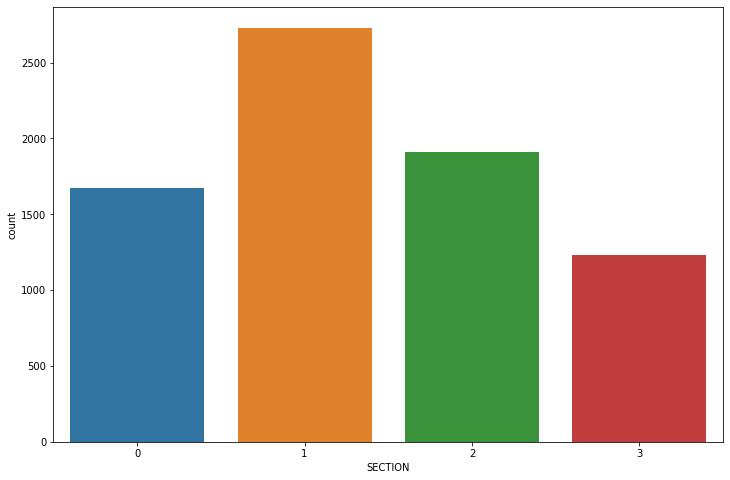

In [17]:
sns.countplot(train.SECTION);

It is clearly evident from the above countplot that the target labels of news category are considerably imbalanced so balanced accuracy needs to be taken into consideration.

In [18]:
encoded_dict = {0: 'Politics', 1: 'Technology', 2: 'Entertainment', 3: 'Business'}
encoded_dict

{0: 'Politics', 1: 'Technology', 2: 'Entertainment', 3: 'Business'}

In [19]:
train['Category'] = train.SECTION.map(encoded_dict)

In [20]:
train.head()

,STORY,SECTION,Category
0,But the most painful was the huge reversal in ...,3,Business
1,How formidable is the opposition alliance amon...,0,Politics
2,Most Asian currencies were trading lower today...,3,Business
3,"If you want to answer any question, click on ...",1,Technology
4,"In global markets, gold prices edged up today ...",3,Business


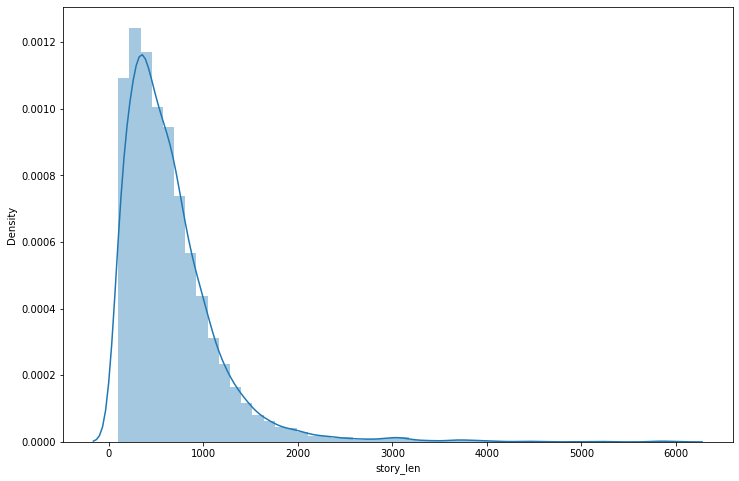

In [21]:
train['story_len'] = train.STORY.apply(len)
sns.distplot(train.story_len);

In [22]:
train.describe()['story_len']

count    7551.000000
mean      653.719375
std       522.283468
min       100.000000
25%       316.000000
50%       537.000000
75%       836.000000
max      6015.000000
Name: story_len, dtype: float64

In [23]:
max_story_len = 400

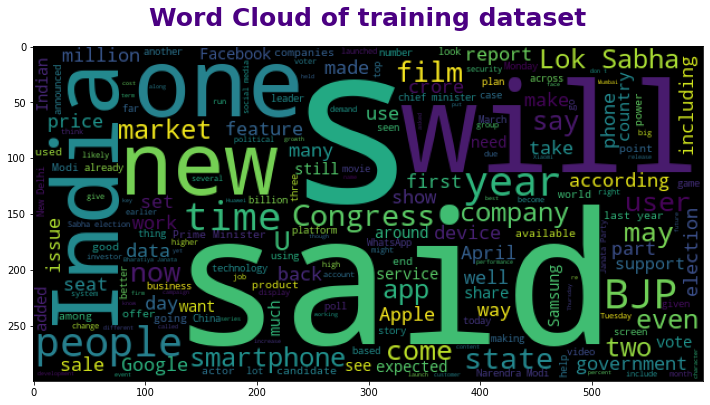

In [24]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(train.STORY))
plt.title('Word Cloud of training dataset',pad=20,color='indigo',fontweight='bold',fontsize=25)
plt.imshow(wc);

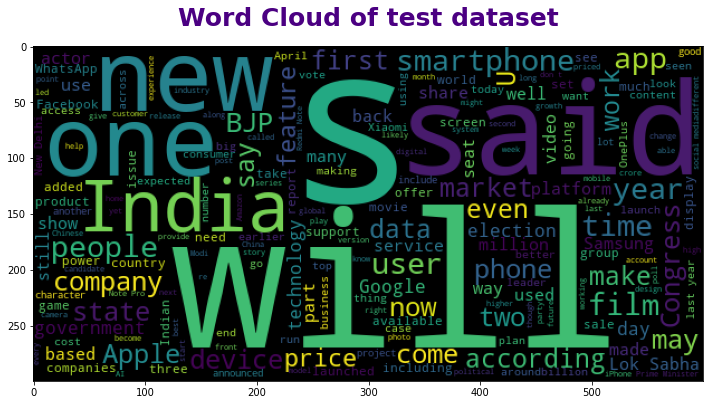

In [25]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(test.STORY))
plt.title('Word Cloud of test dataset',pad=20,color='indigo',fontweight='bold',fontsize=25)
plt.imshow(wc);

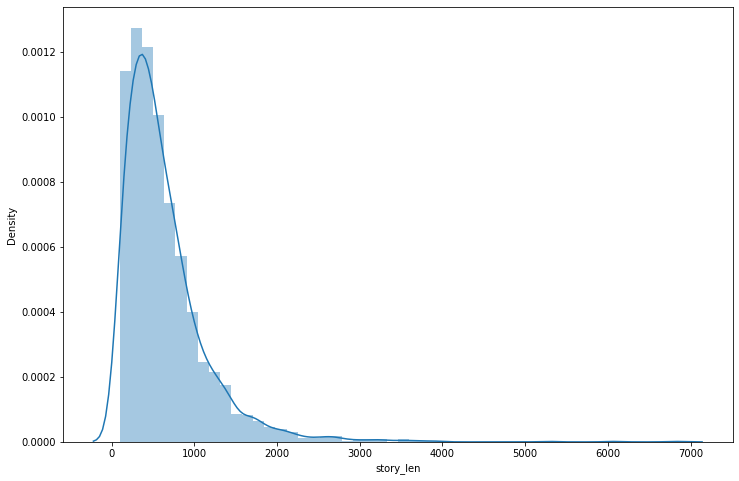

In [26]:
test['story_len'] = test.STORY.apply(len)
sns.distplot(test.story_len);

In [27]:
test.describe()

,story_len
count,2737.000000
mean,640.393862
std,519.243541
min,100.000000
25%,305.000000
50%,512.000000
75%,809.000000
max,6820.000000


## Text Cleaning and Preprocessing

In [28]:
def preprocess_text(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=lower)
    data[col] = data[col].apply(func=non_ascii)
    return data

In [29]:
preprocessed_train = preprocess_text(train,'STORY')
preprocessed_train.head()

,STORY,SECTION,Category,story_len
0,but painful huge reversal fee income unheard a...,3,Business,843
1,how formidable opposition alliance among congr...,0,Politics,129
2,most asian currencies trading lower today sout...,3,Business,386
3,if want answer question click answer after cli...,1,Technology,587
4,in global markets gold prices edged today disa...,3,Business,299


In [30]:
preprocessed_test = preprocess_text(test,'STORY')
preprocessed_test.head()

,STORY,story_len
0,see gadgets gaming smartphones wearable medica...,1558
1,also unleashed wave changes mcu make sure futu...,250
2,confusing pick right smartphone segregated top...,1602
3,the mobile application integrated dashboard co...,813
4,we rounded gadgets showed left indelible mark ...,1263


## Downloading the tokenizer and transformer model

In [31]:
tokenizer = AutoTokenizer.from_pretrained("Neha2608/distilbert-base-uncased-finetuned-news-category")
bert_model = TFAutoModelForSequenceClassification.from_pretrained("Neha2608/distilbert-base-uncased-finetuned-news-category",from_pt=True)

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/939 [00:00<?, ?B/s]

2023-01-16 12:24:24.392953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 12:24:24.393993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 12:24:24.395078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 12:24:24.395860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 12:24:24.396615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

2023-01-16 12:24:42.018529: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## Splitting the datasets into train and test sets

In [32]:
train_df, test_df = train_test_split(preprocessed_train,test_size=0.3,shuffle=True,random_state=101,stratify=preprocessed_train.SECTION)

In [33]:
print("No. of rows in training set:", train_df.shape[0])
print("No. of rows in validation set:", test_df.shape[0])

No. of rows in training set: 5285
No. of rows in validation set: 2266


## Performing text tokenization

In [34]:
X_train = tokenizer(train_df.STORY.tolist(),
                   padding=True,
                   truncation=True,
                   max_length=max_story_len,
                   add_special_tokens=True,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

X_val = tokenizer(test_df.STORY.tolist(),
                   padding=True,
                   truncation=True,
                   max_length=max_story_len,
                   add_special_tokens=True,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

## Encoding the target labels

In [35]:
y_train = to_categorical(train_df.SECTION)
y_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [36]:
y_val = to_categorical(test_df.SECTION)
y_val

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

## Defining and fine-tuning the model architecture

In [37]:
input_ids = Input(shape=(max_story_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_story_len,),name='attention_mask',dtype=tf.int32)

In [38]:
word_embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0 --> last hidden state, 1 --> final pooling output
output = Flatten()(word_embeddings)
output = Dense(units=512,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.15)(output)
output = Dense(units=32,activation='relu')(output)
output = Dense(units=4,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

## Visualizing the model architecture

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 400)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 400)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_for_sequence_cla TFSequenceClassifier 66958855    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
flatten (Flatten)               (None, 7)            0           tf_distil_bert_for_sequence_c

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


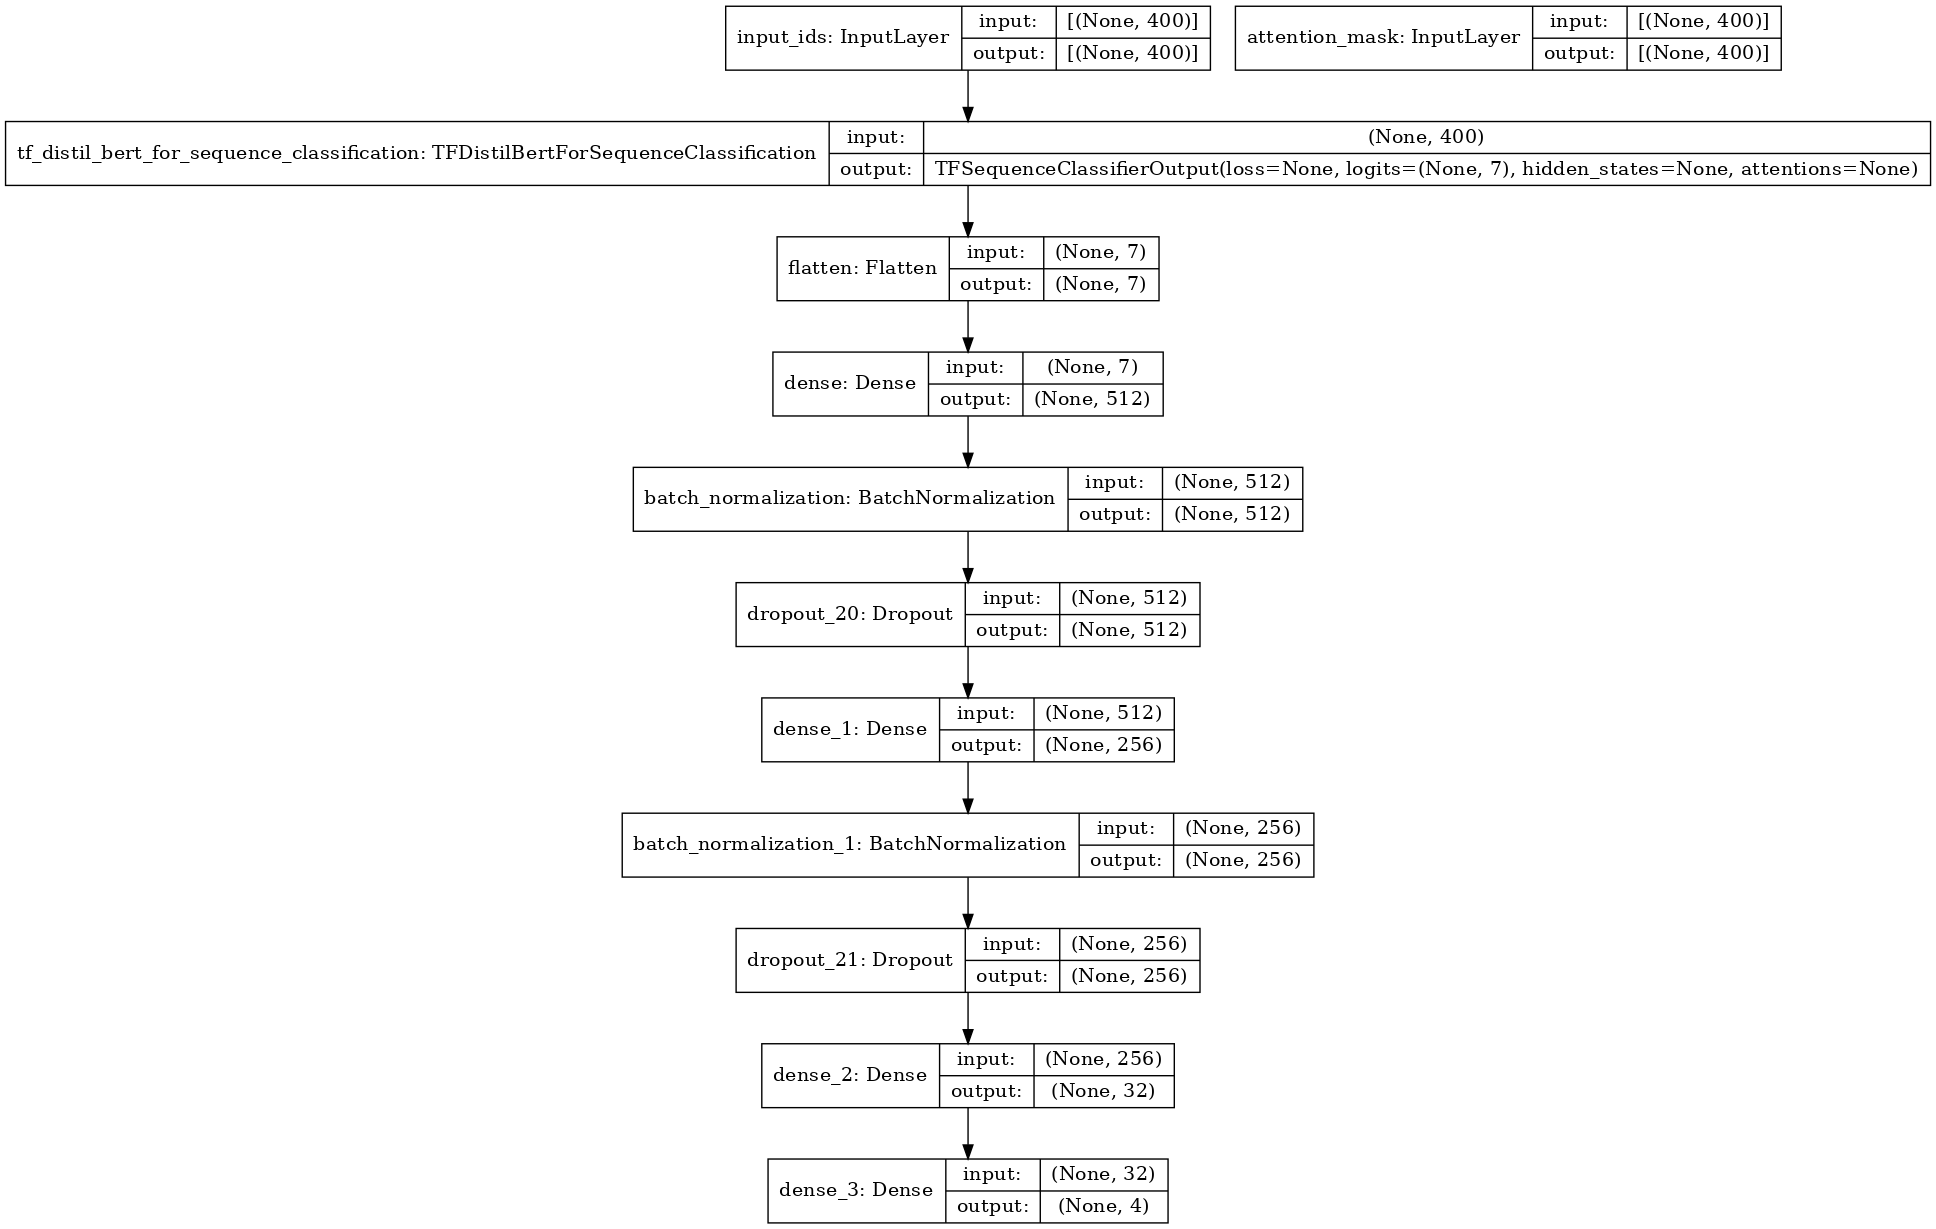

In [40]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

## Compiling the model

In [41]:
adam = Adam(learning_rate=5e-5,
            epsilon=2e-7,
            decay=1e-2,
            clipnorm=1.0)

model.compile(loss=CategoricalCrossentropy(from_logits=True),optimizer=adam,metrics=CategoricalAccuracy('balanced_accuracy'))

X_train = tokenizer(train_df.STORY.tolist(),
                   padding=True,
                   truncation=True,
                   max_length=max_story_len,
                   add_special_tokens=True,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)X_train = tokenizer(train_df.STORY.tolist(),
                   padding=True,
                   truncation=True,
                   max_length=max_story_len,
                   add_special_tokens=True,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)## Training the fine-tuned BERT model

## Training the fine-tuned BERT transformer model

In [42]:
es = EarlyStopping(monitor='val_balanced_accuracy',
                  patience=70,
                  verbose=1,
                  restore_best_weights=True,
                  mode='max')
mc = ModelCheckpoint(filepath='news_category_classifier.h5',
                    monitor='val_balanced_accuracy',
                    verbose=1,
                    save_best_only=True,
                    mode='max')

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
          y=y_train,
          epochs=100,
          batch_size=32,
          callbacks=[es,mc],
          validation_data=({'input_ids': X_val['input_ids'], 'attention_mask': X_val['attention_mask']},y_val))

2023-01-16 12:24:53.907530: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
166/166 [==============================] - 255s 1s/step - loss: 0.4068 - balanced_accuracy: 0.8725 - val_loss: 0.2746 - val_balanced_accuracy: 0.9616

Epoch 00001: val_balanced_accuracy improved from -inf to 0.96161, saving model to news_category_classifier.h5
Epoch 2/100
166/166 [==============================] - 247s 1s/step - loss: 0.1100 - balanced_accuracy: 0.9771 - val_loss: 0.1303 - val_balanced_accuracy: 0.9660

Epoch 00002: val_balanced_accuracy improved from 0.96161 to 0.96602, saving model to news_category_classifier.h5
Epoch 3/100
166/166 [==============================] - 247s 1s/step - loss: 0.0717 - balanced_accuracy: 0.9852 - val_loss: 0.1233 - val_balanced_accuracy: 0.9709

Epoch 00003: val_balanced_accuracy improved from 0.96602 to 0.97087, saving model to news_category_classifier.h5
Epoch 4/100
166/166 [==============================] - 246s 1s/step - loss: 0.0531 - balanced_accuracy: 0.9902 - val_loss: 0.1302 - val_balanced_accuracy: 0.9682

Epoch 00004:

## Visualizing model performance

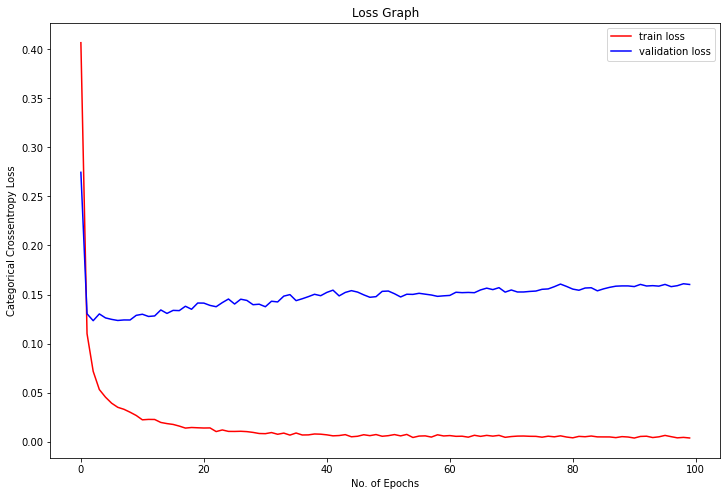

In [43]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

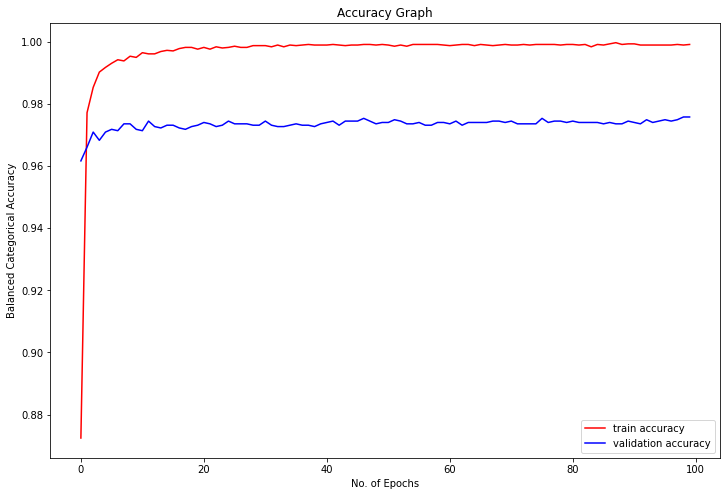

In [44]:
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Balanced Categorical Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Evaluating the model on the validation set

In [45]:
loss, acc = model.evaluate({'input_ids': X_val['input_ids'], 'attention_mask': X_val['attention_mask']},y_val)
print("Validation Categorical Crossentropy Loss:", loss)
print("Validation Balanced Categorical Accuracy:", acc)

71/71 [==============================] - 33s 461ms/step - loss: 0.1602 - balanced_accuracy: 0.9757
Validation Categorical Crossentropy Loss: 0.16023604571819305
Validation Balanced Categorical Accuracy: 0.9757281541824341


## Generating predictions on the test dataset

In [46]:
X_test = tokenizer(preprocessed_test.STORY.tolist(),
                   padding=True,
                   truncation=True,
                   max_length=max_story_len,
                   add_special_tokens=True,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
test_predictions

array([1, 1, 1, ..., 1, 0, 1])

In [47]:
np.unique(test_predictions)

array([0, 1, 2, 3])